Análisis de datos usando  PySpark SQL
===

* *30 min* | Última modificación: Junio 22, 2019

En este tutorial se presenta el análisis de una base de datos sobre vuelos usando SQL en Spark desde la interfaz de Python. En este documento se ejemplifica el uso de DataFrames para la realización de consultas usando sus funciones nativas, como también el envio de comandos SQL. Adicionalmente, se demuestra como salvar los resultados al HDFS en distintos formatos. 

Al finalizar este documento, el lector estará en capacidad de:

* Mover archivos entre el HDFS y el sistema local.

* Importar tablas en formato CSV a PySpark.

* Aplicar operadores de selección, filtrado y agregación desde Python.

* Usar los resultados obtenidos para construir gráficos.

* Exportar los resultados a archivos en el sistema HDFS.

Este ejemplo está basado en el tutorial de Spark de HortoWorks, disponible en https://es.hortonworks.com/tutorial/learning-spark-sql-with-zeppelin/

## Descripción de los campos del archivo

El archivo usado contiene la información sobre vuelos entre 1987 y 2008, y cuenta con los siguientes campos:

* Year: 1987-2008

* Month: 1-12

* DayofMonth: 1-31

* DayOfWeek: 1 (Monday) - 7 (Sunday)

* DepTime: actual departure time (local, hhmm)

* CRSDepTime: scheduled departure time (local, hhmm)

* ArrTime: actual arrival time (local, hhmm)

* CRSArrTime: scheduled arrival time (local, hhmm)

* UniqueCarrier: unique carrier code

* FlightNum: flight number

* TailNum: plane tail number

* ActualElapsedTime: in minutes

* CRSElapsedTime: in minutes

* AirTime: in minutes

* ArrDelay: arrival delay, in minutes

* DepDelay: departure delay, in minutes

* Origin: origin IATA airport code

* Dest: destination IATA airport code

* Distance: in miles

* TaxiIn: taxi in time, in minutes

* TaxiOut: taxi out time in minutes

* Cancelled: was the flight cancelled?

* CancellationCode: reason for cancellation (A = carrier, B = weather, C = NAS, D = security)

* Diverted: 1 = yes, 0 = no

* CarrierDelay: in minutes

* WeatherDelay: in minutes

* NASDelay: in minutes

* SecurityDelay: in minutes

* LateAircraftDelay: in minutes

## Preparación

In [1]:
import findspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

findspark.init()
sparkConf = SparkConf().setAppName("Flights SparkQL Application") 
sc = SparkContext(conf=sparkConf)
spark = SparkSession(sc)

## Copia de archivos al HDFS

In [2]:
##
## El archivo flights.csv se encuentra en la capeta de
## trabajo de la máquina local. Se copia el archivo 
## a la carpeta /tmp del sistema HDFS.
##
!hdfs dfs -copyFromLocal flights.csv /tmp/

##
## Se listan los archivos en la carpeta /tmp del HDFS
## para verificar que el archivo haya sido copiado
##
!hdfs dfs -ls /tmp/*csv

-rw-r--r--   1 vagrant supergroup    9719582 2019-05-20 21:43 /tmp/flights.csv


## Carga de datos en Spark

In [3]:
##
## Crea un DataFrame a partir del archivo fligths.csv
##
flights = spark.read.load("/tmp/flights.csv",
                          format="csv", 
                          sep=",", 
                          inferSchema="true", 
                          header="true")

In [4]:
##
## Se imprime el esquema para verificar la lectura
## del archivo.
##
flights.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Ca

In [5]:
## 
## Se imprime un subconjunto de las columnas para verificar
## la lectura
##
flights.select(['UniqueCarrier', 'FlightNum', 'DepDelay', 'ArrDelay', 'Distance']).show(5)

+-------------+---------+--------+--------+--------+
|UniqueCarrier|FlightNum|DepDelay|ArrDelay|Distance|
+-------------+---------+--------+--------+--------+
|           WN|      335|       8|     -14|     810|
|           WN|     3231|      19|       2|     810|
|           WN|      448|       8|      14|     515|
|           WN|     1746|      -4|      -6|     515|
|           WN|     3920|      34|      34|     515|
+-------------+---------+--------+--------+--------+
only showing top 5 rows



In [6]:
##
## Número total de registros leidos
##
numTotalFlights = flights.count()
numTotalFlights

100000

## Cálculos usando funciones de los DataFrames

### Cómputo del porcentaje de vuelos retrasados

In [7]:
##
## La variable delayedFlights contiene las columnas UniqueCarrier y DepDelay 
## para los vuelos con DepDelay > 15 minutos.
##
delayedFlights = flights.select(['UniqueCarrier', 'DepDelay']).filter(flights['DepDelay'] > 15)
delayedFlights.show(5)

+-------------+--------+
|UniqueCarrier|DepDelay|
+-------------+--------+
|           WN|      19|
|           WN|      34|
|           WN|      25|
|           WN|      67|
|           WN|      94|
+-------------+--------+
only showing top 5 rows



In [8]:
##
## Porcentaje de vuelos retrasados.
##
numDelayedFlights = delayedFlights.count()
print("Porcentaje de vuelos retrasados: " + str(numDelayedFlights / numTotalFlights * 100) + "%")

Porcentaje de vuelos retrasados: 19.587%


### Creación de variables usando funciones de usuario

A continuación se desea crear una nueva columna llamada `IsDelayed` que vale 0 si el vuelo se realizó a tiempo y 1 si se retraso. Ya que la nueva columna, es computada como función de otra, se una una función de usuario (o udf) programada en Python.

In [9]:
##
## Esta función se aplicará sobre el DataFrame.
## El parámetro time será la columna DepDelay
##
def is_delayed_py(time):
    if time == "NA":
        return 0 
    elif int(time) > 15:
        return 1 
    else: 
        return 0

A continuación se registra la función en Spark y se aplica sobre el Dataframe.

In [10]:
##
## Importa la función udf que permite registra funciones 
## escritas en Python dentro de Spark
## 
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType

##
## Se registra la función con el tipo de dato que devuelve.
## is_delayed_udf corresponde a la función registrada en Spark.
## Adicionalmente, se indica el tipo de dato que devuelve.
##
is_delayed_udf = udf(is_delayed_py, LongType())

##
## Se crea un nuevo DataFrame que contiene la columna 
## IsDelayed, la cual es computada con la udf
##
flightsWithDelays = flights.select('Year', 
                                   'Month', 
                                   'DayofMonth', 
                                   'UniqueCarrier', 
                                   'FlightNum', 
                                   'DepDelay',
                                   is_delayed_udf("DepDelay").alias("IsDelayed"))

##
## Se imprimen algunos registros para verificar el resultado.
##
flightsWithDelays.select('DepDelay', 'isDelayed').show(20)

+--------+---------+
|DepDelay|isDelayed|
+--------+---------+
|       8|        0|
|      19|        1|
|       8|        0|
|      -4|        0|
|      34|        1|
|      25|        1|
|      67|        1|
|      -1|        0|
|       2|        0|
|       0|        0|
|       6|        0|
|      94|        1|
|      -4|        0|
|       0|        0|
|       2|        0|
|       9|        0|
|      27|        1|
|       9|        0|
|      28|        1|
|      51|        1|
+--------+---------+
only showing top 20 rows



In [11]:
## 
## A continuación, se calcula el porcentaje de vuelos con retrasos
##
from pyspark.sql import functions as F
flightsWithDelays.agg((F.sum('IsDelayed') * 100 / F.count('DepDelay')) \
                      .alias("Porcentaje de vuelos retrasados")).show()

+-------------------------------+
|Porcentaje de vuelos retrasados|
+-------------------------------+
|                         19.587|
+-------------------------------+



### Cómputo de los tiempos promedio de despegue (Taxi-in)

In [12]:
##
## En este código se ilustra como computar un promedio 
## y luego realizar el ordenamiento de la tabla por
## ese mismo promedio.
##
(flights.select("Origin", "Dest", "TaxiIn") \
    .groupBy("Origin", "Dest") \
    .agg(F.avg("TaxiIn").alias("AvgTaxiIn"))) \
        .orderBy("AvgTaxiIn", ascending = False) \
        .show(10)                                  

+------+----+------------------+
|Origin|Dest|         AvgTaxiIn|
+------+----+------------------+
|   CLT| IAH|              22.0|
|   IAH| ABQ|              18.0|
|   MCI| IAH|14.666666666666666|
|   BHM| EWR|              13.0|
|   SMF| GEG|12.462962962962964|
|   MHT| CLE|              12.0|
|   CRW| IAH|              12.0|
|   IAH| JAX|              11.0|
|   ONT| COS|10.903225806451612|
|   SMF| COS|10.610169491525424|
+------+----+------------------+
only showing top 10 rows



### Cómputo de los tiempos promedio de aterrizaje

In [13]:
##
## En este código se ilustra como computar un promedio 
## y luego realizar el ordenamiento de la tabla por
## ese mismo promedio.
##
(flights.select("Origin", "Dest", "TaxiOut") \
    .groupBy("Origin", "Dest") \
    .agg(F.avg("TaxiOut").alias("AvgTaxiOut"))) \
        .orderBy("AvgTaxiOut", ascending = False) \
        .show(10)

+------+----+----------+
|Origin|Dest|AvgTaxiOut|
+------+----+----------+
|   LCH| IAH|      84.0|
|   EWR| BHM|      63.0|
|   EWR| SDF|      45.0|
|   EWR| GSO|      36.5|
|   MHT| CLE|      33.0|
|   EWR| JAX|      28.0|
|   EWR| DTW|      27.0|
|   CLE| SDF|      27.0|
|   ORD| EWR|      26.0|
|   EWR| MCI|      26.0|
+------+----+----------+
only showing top 10 rows



## Cómputos usando SQL

A continuación se realizan los mismos cálculos anteriores, pero usando SQL desde Spark.

In [14]:
## 
## Se crea la tabla
##
flights.createOrReplaceTempView('flightsView')

In [15]:
##
## Se registra la función para usar con Spark SQL
## 
from pyspark.sql.types import LongType

## Registra la función.
spark.udf.register('isDelayed_SQL', is_delayed_py)

## Aplica la función
spark.sql("""
SELECT 
    DepDelay, 
    isDelayed_SQL(DepDelay) as isDelayed 
FROM 
    flightsView
""").show(20)

+--------+---------+
|DepDelay|isDelayed|
+--------+---------+
|       8|        0|
|      19|        1|
|       8|        0|
|      -4|        0|
|      34|        1|
|      25|        1|
|      67|        1|
|      -1|        0|
|       2|        0|
|       0|        0|
|       6|        0|
|      94|        1|
|      -4|        0|
|       0|        0|
|       2|        0|
|       9|        0|
|      27|        1|
|       9|        0|
|      28|        1|
|      51|        1|
+--------+---------+
only showing top 20 rows



In [16]:
##
## Numero total de retrasos por transportador
##
spark.sql("""
SELECT 
    UniqueCarrier, 
    SUM(isDelayed_SQL(DepDelay)) AS NumDelays 
FROM 
    flightsView 
GROUP BY 
    UniqueCarrier
""").show()

+-------------+---------+
|UniqueCarrier|NumDelays|
+-------------+---------+
|           XE|   1014.0|
|           WN|  18573.0|
+-------------+---------+



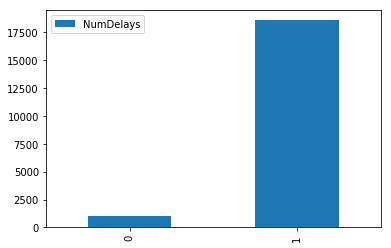

In [17]:
%matplotlib inline

spark.sql("""
SELECT 
    UniqueCarrier, 
    SUM(isDelayed_SQL(DepDelay)) AS NumDelays 
FROM 
    flightsView 
GROUP BY 
    UniqueCarrier
""").toPandas().plot.bar();

In [18]:
##
## Tiempo total de retrasos por transportador
##
spark.sql("""
SELECT 
    UniqueCarrier, 
    SUM(DepDelay) AS TotalTimeDelay 
FROM 
    flightsView 
GROUP BY 
    UniqueCarrier
""").show()

+-------------+--------------+
|UniqueCarrier|TotalTimeDelay|
+-------------+--------------+
|           XE|       47505.0|
|           WN|      978547.0|
+-------------+--------------+



In [19]:
##
## Distancia recorrida por operador
##
spark.sql("""
SELECT 
    UniqueCarrier, 
    avg(Distance) AS AvgDistanceTraveled 
FROM 
    flightsView 
GROUP BY 
    UniqueCarrier 
ORDER BY 
    AvgDistanceTraveled DESC
""").show()

+-------------+-------------------+
|UniqueCarrier|AvgDistanceTraveled|
+-------------+-------------------+
|           XE|  738.0677880571909|
|           WN|  623.7926638668864|
+-------------+-------------------+



### Retrasos por día de la semana

In [20]:
spark.sql("""
SELECT 
    DayOfWeek, 
    delayed,
    COUNT(1) AS Count
FROM
    (SELECT
        DayOfWeek,
        isDelayed_SQL(DepDelay) AS delayed
     FROM
        flightsView)
GROUP BY 
    DayOfWeek, 
    delayed
ORDER BY 
    DayOfWeek
""").show()

+---------+-------+-----+
|DayOfWeek|delayed|Count|
+---------+-------+-----+
|        1|      0|11863|
|        1|      1| 2656|
|        2|      0|12911|
|        2|      1| 1799|
|        3|      1| 1434|
|        3|      0|13260|
|        4|      0|12271|
|        4|      1| 4808|
|        5|      1| 3514|
|        5|      0|11003|
|        6|      0| 9407|
|        6|      1| 1878|
|        7|      0| 9698|
|        7|      1| 3498|
+---------+-------+-----+



### Retrasos por hora del día

In [21]:
spark.sql("""
SELECT 
    Hour,
    delayed, 
    COUNT(1) AS Count
FROM 
(
    SELECT
        CAST(CRSDepTime / 100 AS INT) AS Hour, 
        isDelayed_SQL(DepDelay) AS delayed
    FROM
        flightsView
)
GROUP BY 
    Hour, 
    delayed
ORDER BY 
    Hour
""").show()

+----+-------+-----+
|Hour|delayed|Count|
+----+-------+-----+
|   6|      1|  208|
|   6|      0| 6126|
|   7|      0| 7274|
|   7|      1|  372|
|   8|      1|  547|
|   8|      0| 5956|
|   9|      1|  761|
|   9|      0| 5861|
|  10|      1|  903|
|  10|      0| 5783|
|  11|      1|  986|
|  11|      0| 5115|
|  12|      0| 5174|
|  12|      1| 1128|
|  13|      0| 5225|
|  13|      1| 1346|
|  14|      0| 4434|
|  14|      1| 1335|
|  15|      0| 4818|
|  15|      1| 1562|
+----+-------+-----+
only showing top 20 rows



## Almacenamiento y lectura de tablas calculadas

### Escritura de resultados en el HDFS con formato ORC

In [22]:
##
## Se salva la tabla calculada al directorio tmp del HDFS.
## Primero se borra si existe.
##
!hdfs dfs -rm -r -f /tmp/flightsWithDelays.orc

## Se salva en formato ORC
flightsWithDelays.write.format("orc").save("/tmp/flightsWithDelays.orc")

In [23]:
##
## Contenido del directorio donde se salvó la tabla
##
!hdfs dfs -ls /tmp/flightsWithDelays.orc

Found 3 items
-rw-r--r--   1 vagrant supergroup          0 2019-05-20 21:43 /tmp/flightsWithDelays.orc/_SUCCESS
-rw-r--r--   1 vagrant supergroup     162174 2019-05-20 21:43 /tmp/flightsWithDelays.orc/part-00000-4d2e6e19-e865-4198-a9ac-656366eeeeb0-c000.snappy.orc
-rw-r--r--   1 vagrant supergroup      69710 2019-05-20 21:43 /tmp/flightsWithDelays.orc/part-00001-4d2e6e19-e865-4198-a9ac-656366eeeeb0-c000.snappy.orc


### Carga de los resultados desde el HDFS

In [24]:
##
## Se lee la tabla calculada desde el HDFS
##
test = spark.read.format("orc").load("/tmp/flightsWithDelays.orc")

## verifica la cantidad de registros.
assert test.count() == flightsWithDelays.count(), print("Archivos con diferentes tamaños.")

### Salva el DataFrame como una tabla permamente

In [25]:
##
## La tabla queda guardada en la carpeta
## spark-warehouse del directorio actual
##
!rm -rf spark-warehouse/flightswithdelaystbl
flightsWithDelays.write.format("orc").saveAsTable("flightswithdelaystbl")

### Tablas almacenadas

In [26]:
spark.sql("SHOW TABLES").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|flightswithdelaystbl|      false|
|        |         flightsview|       true|
+--------+--------------------+-----------+



## Consultas en un tabla permanente

In [27]:
## 
## Note que cuando la tabla está almacenada de forma
## permanente no es necesario cargarla a la memoria
## para poder usarla.
##
spark.sql("SELECT COUNT(1) AS Total from flightswithdelaystbl").show()  

+------+
| Total|
+------+
|100000|
+------+



In [28]:
## Se borran las tablas para limpiar el área
## de trabajo.
spark.sql("DROP TABLE flightswithdelaystbl")
spark.sql("SHOW TABLES").show()

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
|        |flightsview|       true|
+--------+-----------+-----------+



---

**Limpieza**

In [29]:
!hdfs dfs -rm /tmp/flights.csv

Deleted /tmp/flights.csv
